' Spam Email Classification Project '

Intro:

This project aims to classify emails as spam or ham (non-spam) using a Convolutional Neural Network (CNN) model. The dataset used includes spam emails, easy ham, and hard ham emails from the SpamAssassin Public Corpus.


1. Import libraries, modules and functions 

In [154]:
import os  #This module provides functions to interact with OS, such as manipulating files and directories
import urllib.request  #Use this module to accesse URLs(open and interact with it,fetching data) and to access resources on the internet
import tarfile         #work with both compressed and uncompressed tar files.
import shutil  #Use this to managing entire directories like copying and removing directories and their contents.
import numpy as np    #numpy=library
import glob  #This is useful for retrieving file and directory names that match a specified pattern.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle    #This fun. used to shuffle/mix the order of elements in an array 
#sklearn==library, utils==module,  shuffle==function
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer  #Tokenizer=class, tensorflow.keras.preprocessing.text=module ==> This for preparing text data
#Tokenizer class used to convert text into sequences of tokens
from tensorflow.keras.preprocessing.sequence import pad_sequences
#pad_sequences function is used to ensure that all sequences in a dataset have the same length by padding shorter sequences and truncating longer ones.
#This is important because neural networks typically require fixed-length inputs.
from tensorflow.keras.models import Sequential 
#The Sequential class is to build and stack layers to create neural network models.
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
import re

2. Load the data

In [155]:
# Directories for data
DATASETS_DIR = 'datasets'
TAR_DIR = os.path.join(DATASETS_DIR, 'tar')

In [156]:
# URLs for SpamAssassin datasets
SPAM_URL = 'https://spamassassin.apache.org/old/publiccorpus/20050311_spam_2.tar.bz2'
EASY_HAM_URL = 'https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham_2.tar.bz2'
HARD_HAM_URL = 'https://spamassassin.apache.org/old/publiccorpus/20030228_hard_ham.tar.bz2'


In [157]:
def download_and_extract_dataset(url):
    """Download and extract dataset from the given URL."""
    if not os.path.isdir(TAR_DIR):
        os.makedirs(TAR_DIR)
    
    filename = url.rsplit('/', 1)[-1]
    tarpath = os.path.join(TAR_DIR, filename)
    
    if not os.path.exists(tarpath):
        urllib.request.urlretrieve(url, tarpath)
    
    with tarfile.open(tarpath, 'r:bz2') as tar:
        dirname = os.path.join(DATASETS_DIR, tar.getnames()[0])
        if os.path.isdir(dirname):
            shutil.rmtree(dirname)
        tar.extractall(path=DATASETS_DIR)
        
        cmds_path = os.path.join(dirname, 'cmds')
        if os.path.isfile(cmds_path):
            os.remove(cmds_path)
    
    return dirname

In [158]:
# Download and extract datasets
spam_dir = download_and_extract_dataset(SPAM_URL)
easy_ham_dir = download_and_extract_dataset(EASY_HAM_URL)
hard_ham_dir = download_and_extract_dataset(HARD_HAM_URL)

In [159]:
def load_dataset(dirpath):
    """Load emails from the specified directory."""
    files = []
    filepaths = glob.glob(dirpath + '/*')
    for path in filepaths:
        with open(path, 'rb') as f:
            byte_content = f.read()
            str_content = byte_content.decode('utf-8', errors='ignore')
            files.append(str_content)
    return files

In [160]:
# Load datasets into Pandas DataFrame
spam = load_dataset(spam_dir)       # Spam emails are unsolicited and often irrelevant messages 
easy_ham = load_dataset(easy_ham_dir)  #Easy ham refers to legitimate, non-spam emails that are relatively straightforward for spam filters to identify as such
hard_ham = load_dataset(hard_ham_dir)
#Hard ham refers to legitimate emails that are more challenging for spam filters to identify correctly
#These emails may contain some features that are similar to spam, making them harder to distinguish from spam emails.

In [161]:
spam_df = pd.DataFrame(spam, columns=['email'])
easy_ham_df = pd.DataFrame(easy_ham, columns=['email'])
hard_ham_df = pd.DataFrame(hard_ham, columns=['email'])

In [106]:
len(spam_df)

1396

In [107]:
len(easy_ham_df)

1400

In [108]:
len(hard_ham_df)

250

In [109]:
hard_ham_df

,email
0,Return-Path: Fool@motleyfool.com\nDelivery-Dat...
1,Return-Path: <malcolm-sweeps@mrichi.com>\nDeli...
2,From nic@starflung.com Mon Jun 24 17:06:54 20...
3,Received: from bran.mc.mpls.visi.com (bran.mc....
4,Return-Path: <iso17799@securityrisk.co.uk>\nRe...
...,...
245,From senews-nov@euromailer.lists.apple.com Th...
246,From imho@eircom.net Thu Nov 28 11:41:56 2002...
247,From bounce-neatnettricks-2424157@silver.lyris...
248,From owner-nolist-seg25187*jm-cuteftp**JMASON*...


In [162]:
# Combine into a single DataFrame
spam_df['label'] = 1
easy_ham_df['label'] = 0
hard_ham_df['label'] = 0

In [163]:
df = pd.concat([spam_df, easy_ham_df, hard_ham_df], ignore_index=True)   #This concatenation operation is used to combine multiple DataFrames into a single DataFrame with new index.

In [164]:
df = shuffle(df, random_state=42).reset_index(drop=True)  #The shuffle function is used to randomly shuffle the rows of a DataFrame.

In [113]:
df

,email,label
0,Received: from hq.pro-ns.net (localhost [127.0...,1
1,From bjchadwick@eudoramail.com Mon Jun 24 17:...,1
2,From fork-admin@xent.com Wed Jul 24 13:20:12 ...,0
3,From Jacquiro@tjohoo.se Sun Dec 1 16:14:33 2...,1
4,From fork-admin@xent.com Wed Jul 24 12:11:00 ...,0
...,...,...
3041,From ilug-admin@linux.ie Tue Aug 6 11:51:25 ...,0
3042,From taxfree7550288@yahoo.com Fri Jul 26 08:1...,1
3043,From gort44@excite.com Mon Jul 29 11:40:11 20...,1
3044,From gyiskcnvbfc@msn.com Tue Aug 6 11:04:46 ...,1


3. Split data

In [165]:
# Split the data into stratified training and test sets
X = df['email'].values  #Extract the email content(feature) from the DataFrame and converts it into a NumPy array (X)
y = df['label'].values  #Extract labels(target) from the df and converts it into a NumPy array (y).

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#This function splits X and y into random train and test subsets.

In [167]:
# Define email cleaning functions
def remove_header(email):
    """Remove the header from an email."""
    return email[email.index('\n\n'):] if '\n\n' in email else email


In [168]:
def is_url(s):
    url = re.match("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|"
                     "[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", s)
    return url is not None

In [169]:
def convert_url_to_word(words):
    """Convert all URLs in the list to the word 'URL'."""
    for i, word in enumerate(words):
        if is_url(word):
            words[i] = 'URL'
    return words

In [170]:
def convert_num_to_word(words):
    """Convert all numbers in the list to the word 'NUM'."""
    for i, word in enumerate(words):
        if word.isdigit():
            words[i] = 'NUM'
    return words

In [171]:
def remove_punctuation(email):
    return ''.join([c if c.isalnum() or c.isspace() else ' ' for c in email])


In [172]:
# Email cleaning pipeline as a class
class CleanEmails:
    def __init__(self, no_header=True, to_lowercase=True, url_to_word=True, num_to_word=True, remove_punc=True):
        self.no_header = no_header
        self.to_lowercase = to_lowercase
        self.url_to_word = url_to_word
        self.num_to_word = num_to_word
        self.remove_punc = remove_punc
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_cleaned = []
        for email in X:
            if self.no_header:
                email = remove_header(email)
            if self.to_lowercase:
                email = email.lower()
            
            email_words = email.split()
            if self.url_to_word:
                email_words = convert_url_to_word(email_words)
            if self.num_to_word:
                email_words = convert_num_to_word(email_words)
            email = ' '.join(email_words)
            if self.remove_punc:
                email = remove_punctuation(email)
            X_cleaned.append(email)
        return X_cleaned

3. Clean the data

In [173]:
# Apply the cleaning pipeline
cleaner = CleanEmails()
X_train_clean = cleaner.transform(X_train)
X_test_clean = cleaner.transform(X_test)

##Text Tokenization and Padding

In [174]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>') #Initialize Tokenizer
tokenizer.fit_on_texts(X_train_clean)   #Fit Tokenizer on Training Data

#Convert Texts to Sequences
#converts each text to a sequence of integers, where each integer corresponds to a token in the tokenizer's word index
X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_test_seq = tokenizer.texts_to_sequences(X_test_clean)

In [132]:
X_test_seq[20]

[3635,
 24,
 245,
 438,
 379,
 7979,
 138,
 24,
 290,
 61,
 7,
 318,
 40,
 773,
 47,
 43,
 1731,
 555,
 1342,
 7,
 43,
 1325,
 883,
 1,
 171,
 52,
 1601,
 161,
 2,
 4191,
 4029,
 27,
 1,
 16,
 6250,
 16,
 24,
 144,
 1,
 3642,
 506,
 171,
 1086,
 43,
 70,
 651,
 175,
 57,
 1066,
 19,
 4625,
 211,
 7591,
 5797,
 250,
 411,
 36,
 729,
 36,
 71,
 769,
 7,
 403,
 120,
 151,
 209,
 224,
 403,
 1745,
 36,
 3584,
 2942,
 1238,
 3686,
 47,
 1452,
 669,
 345,
 36,
 77,
 49,
 1214,
 1,
 1269,
 8250,
 6250,
 1696,
 41,
 32,
 2,
 298,
 1192,
 737,
 24,
 245,
 179,
 2802,
 128,
 5,
 392,
 647,
 27,
 2,
 1544,
 17,
 780,
 124,
 106,
 608,
 1545,
 41,
 479,
 8371,
 7,
 4861,
 118,
 73,
 43,
 900,
 145,
 1828,
 77,
 85,
 41,
 32,
 7,
 5161,
 417,
 77,
 5,
 6236,
 43,
 32,
 7979,
 137,
 265,
 20,
 82,
 117,
 555,
 629,
 72,
 1522,
 20,
 273,
 2547,
 386,
 120,
 166,
 260,
 403,
 120,
 151,
 35,
 27,
 409,
 239,
 133,
 98,
 451,
 455,
 120,
 151,
 386,
 120,
 166,
 260,
 403,
 120,
 151,
 35,
 27,
 409,


In [175]:
max_length = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

In [135]:
X_test_pad

array([[  59,  172,  127, ..., 4207,  372,   40],
       [  47,  699,  612, ...,    2,    1,  371],
       [ 882,  169,   24, ...,  263,   52, 4736],
       ...,
       [  65,  866,   47, ...,    0,    0,    0],
       [ 146,  318,  140, ...,  355,   27,  748],
       [  57, 5428,    1, ...,    0,    0,    0]])

4. Build Deep Learning Model

In [203]:
# Build the CNN model for text classification using Keras (tensorflow.keras)
model = Sequential([             
    Embedding(10000, 128, input_length=max_length),   # Embedding layer
    Conv1D(128, 5, activation='relu'),                # 1st Conv1D layer
    MaxPooling1D(pool_size=2),                        # MaxPooling1D layer
    Conv1D(128, 5, activation='relu'),                # 2nd Conv1D layer
    GlobalMaxPooling1D(),                             # GlobalMaxPooling1D layer
    Dense(128, activation='relu'),                    # Dense layer with ReLU activation
    Dropout(0.5),                                     # Dropout layer
    Dense(1, activation='sigmoid')                    # Output layer with Sigmoid activation
])

In [137]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 conv1d_8 (Conv1D)           (None, 196, 128)          82048     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 98, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 94, 128)           82048     
                                                                 
 global_max_pooling1d_4 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_8 (Dense)             (None, 128)              

In [204]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#Compiling the model in Keras involves setting up the optimizer, loss function, and metrics for training
#Optimizers are algorithms that update the weights of the neural network during training to minimize the loss function.
#The loss function computes the difference between the predicted outputs and the actual targets during training.
#Metrics are used to evaluate the performance of the model.

5. Train

In [205]:
# Train the model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/10
77/77 [==============================] - 5s 51ms/step - loss: 0.4575 - accuracy: 0.7627 - val_loss: 0.2234 - val_accuracy: 0.9164
Epoch 2/10
77/77 [==============================] - 4s 47ms/step - loss: 0.0893 - accuracy: 0.9733 - val_loss: 0.1293 - val_accuracy: 0.9525
Epoch 3/10
77/77 [==============================] - 4s 47ms/step - loss: 0.0193 - accuracy: 0.9955 - val_loss: 0.1858 - val_accuracy: 0.9574
Epoch 4/10
77/77 [==============================] - 4s 49ms/step - loss: 0.0100 - accuracy: 0.9971 - val_loss: 0.1794 - val_accuracy: 0.9590
Epoch 5/10
77/77 [==============================] - 4s 49ms/step - loss: 0.0068 - accuracy: 0.9996 - val_loss: 0.1918 - val_accuracy: 0.9557
Epoch 6/10
77/77 [==============================] - 4s 50ms/step - loss: 0.0070 - accuracy: 0.9992 - val_loss: 0.1789 - val_accuracy: 0.9557
Epoch 7/10
77/77 [==============================] - 4s 47ms/step - loss: 0.0085 - accuracy: 0.9992 - val_loss: 0.1775 - val_accuracy: 0.9607
Epoch 8/10
77

6. Evaluate

In [206]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy}')

20/20 [==============================] - 0s 13ms/step - loss: 0.2259 - accuracy: 0.9541
Test Accuracy: 0.9540983438491821


In [207]:
# Predict on test data
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

20/20 [==============================] - 0s 13ms/step


In [208]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       330
           1       0.93      0.98      0.95       280

    accuracy                           0.95       610
   macro avg       0.95      0.96      0.95       610
weighted avg       0.96      0.95      0.95       610



7. Plot Performance

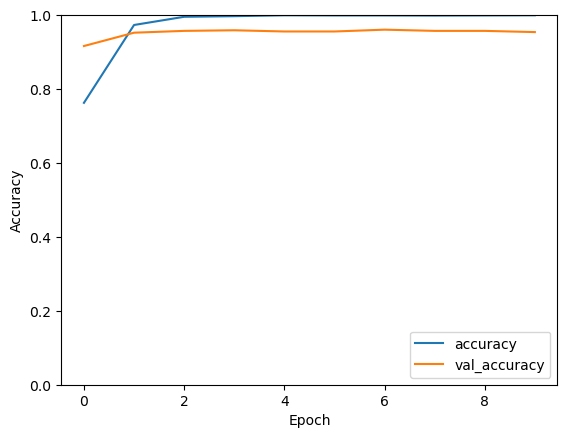

In [209]:
# Plotting the training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

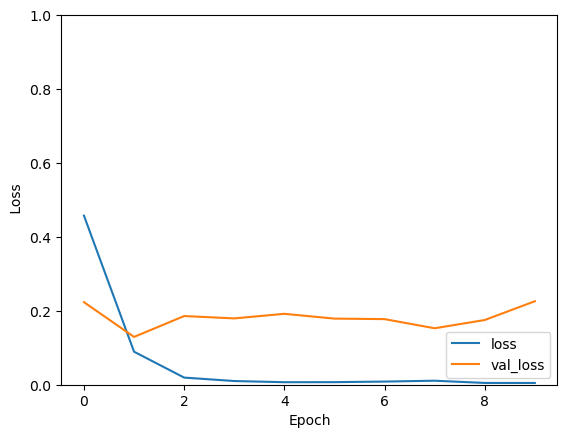

In [210]:
# try this, this is for loss
# import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel(' Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

#this plot shows the training loss and validation loss of the CNN model over 10 epochs.

Outro:


The CNN model demonstrates excellent performance in classifying emails as spam or ham, with high precision, recall, and F1-scores across both classes. The high accuracy of 95.41% on the test data confirms the model's effectiveness in distinguishing between spam and non-spam emails. This model can be a valuable tool for email filtering, helping to reduce the amount of unwanted spam in users inboxes.


But through the execution of the plot, I've noticed there is overfitting, so I need to do something to modify this.

_______________________________________________________________________________

There is overfitting and I will try some things to reduce it

In [184]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Embedding(10000, 128, input_length=max_length),
    Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01)),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

In [185]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [186]:
# Train the model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/10
77/77 [==============================] - 6s 57ms/step - loss: 2.0178 - accuracy: 0.5521 - val_loss: 0.9466 - val_accuracy: 0.5410
Epoch 2/10
77/77 [==============================] - 4s 51ms/step - loss: 0.6156 - accuracy: 0.8005 - val_loss: 0.3641 - val_accuracy: 0.9344
Epoch 3/10
77/77 [==============================] - 4s 52ms/step - loss: 0.2851 - accuracy: 0.9594 - val_loss: 0.3550 - val_accuracy: 0.9213
Epoch 4/10
77/77 [==============================] - 4s 52ms/step - loss: 0.2197 - accuracy: 0.9807 - val_loss: 0.2669 - val_accuracy: 0.9541
Epoch 5/10
77/77 [==============================] - 4s 51ms/step - loss: 0.1852 - accuracy: 0.9885 - val_loss: 0.2874 - val_accuracy: 0.9410
Epoch 6/10
77/77 [==============================] - 4s 50ms/step - loss: 0.1607 - accuracy: 0.9930 - val_loss: 0.2545 - val_accuracy: 0.9508
Epoch 7/10
77/77 [==============================] - 4s 51ms/step - loss: 0.1468 - accuracy: 0.9971 - val_loss: 0.2511 - val_accuracy: 0.9541
Epoch 8/10
77

In [187]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy}')

20/20 [==============================] - 0s 15ms/step - loss: 0.2477 - accuracy: 0.9508
Test Accuracy: 0.9508196711540222


In [188]:
# Predict on test data
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

20/20 [==============================] - 0s 13ms/step


In [189]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       330
           1       0.93      0.96      0.95       280

    accuracy                           0.95       610
   macro avg       0.95      0.95      0.95       610
weighted avg       0.95      0.95      0.95       610



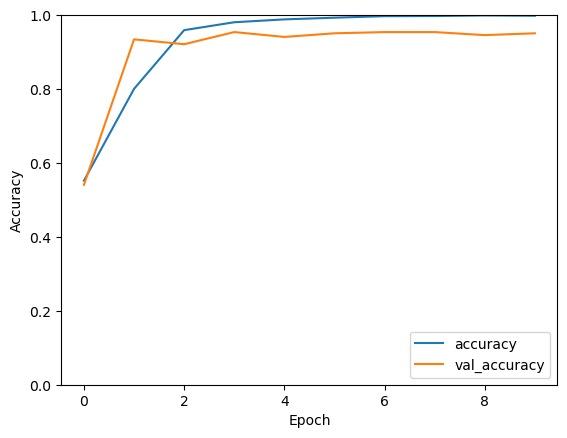

In [190]:
# Plotting the training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

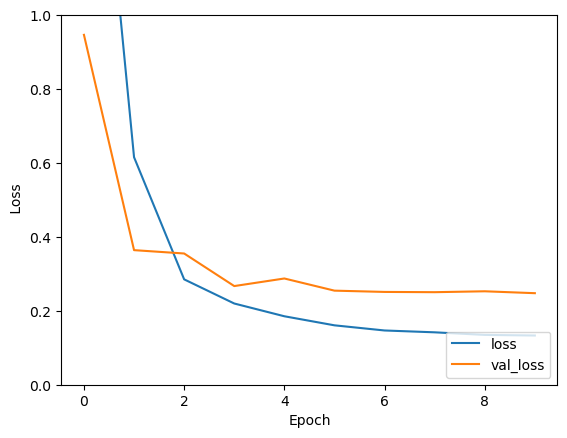

In [191]:
# try this, this is for loss
# import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel(' Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

#this plot shows the training loss and validation loss of the CNN model over 10 epochs.

socond thing I will do it:

In [192]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Embedding(10000, 128, input_length=max_length),
    Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

In [193]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [194]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_pad, y_train, epochs=20, batch_size=32, validation_data=(X_test_pad, y_test), callbacks=[early_stopping])


Epoch 1/20
77/77 [==============================] - 9s 76ms/step - loss: 3.9211 - accuracy: 0.8202 - val_loss: 3.6932 - val_accuracy: 0.5590
Epoch 2/20
77/77 [==============================] - 5s 70ms/step - loss: 2.6938 - accuracy: 0.9848 - val_loss: 2.9349 - val_accuracy: 0.5607
Epoch 3/20
77/77 [==============================] - 5s 67ms/step - loss: 2.0258 - accuracy: 0.9914 - val_loss: 2.3645 - val_accuracy: 0.9082
Epoch 4/20
77/77 [==============================] - 5s 62ms/step - loss: 1.6155 - accuracy: 0.9795 - val_loss: 1.9525 - val_accuracy: 0.9246
Epoch 5/20
77/77 [==============================] - 5s 60ms/step - loss: 1.3117 - accuracy: 0.9828 - val_loss: 1.5892 - val_accuracy: 0.9541
Epoch 6/20
77/77 [==============================] - 5s 62ms/step - loss: 1.0038 - accuracy: 0.9922 - val_loss: 1.2036 - val_accuracy: 0.9557
Epoch 7/20
77/77 [==============================] - 5s 59ms/step - loss: 0.7622 - accuracy: 0.9988 - val_loss: 0.8722 - val_accuracy: 0.9607
Epoch 8/20
77

In [195]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy}')

20/20 [==============================] - 0s 15ms/step - loss: 0.3259 - accuracy: 0.9689
Test Accuracy: 0.9688524603843689


In [196]:
# Predict on test data
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

20/20 [==============================] - 1s 15ms/step


In [197]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       330
           1       0.97      0.96      0.97       280

    accuracy                           0.97       610
   macro avg       0.97      0.97      0.97       610
weighted avg       0.97      0.97      0.97       610



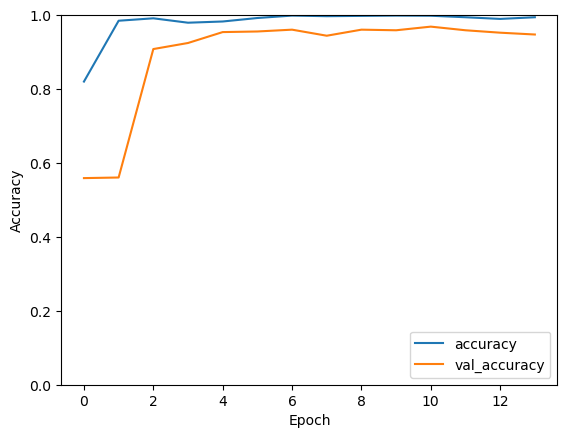

In [198]:
# Plotting the training history
# drop out to be more noisy to be correct
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

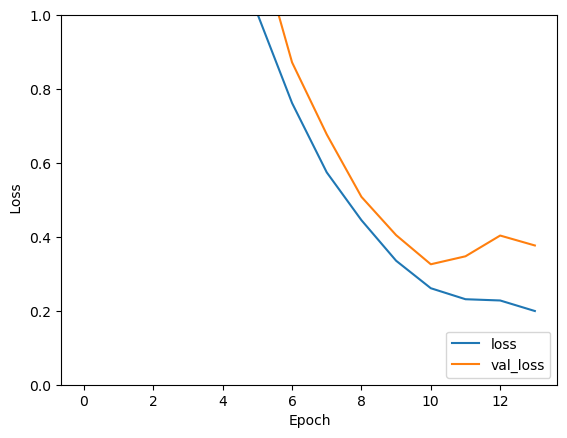

In [199]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel(' Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [200]:
# Function to predict if an email is spam or not
def predict_spam(email):
    cleaned_email = cleaner.transform([email])
    seq = tokenizer.texts_to_sequences(cleaned_email)
    pad_seq = pad_sequences(seq, maxlen=max_length, padding='post', truncating='post')
    prediction = model.predict(pad_seq)
    return 'spam' if prediction[0][0] > 0.5 else 'ham'

In [201]:
# Example usage
email_example = spam_df.email[100]
print(predict_spam(email_example))

1/1 [==============================] - 0s 51ms/step
spam


In [202]:
# Example usage
email_example = easy_ham_df.email[100]
print(predict_spam(email_example))

1/1 [==============================] - 0s 40ms/step
ham
